IMPORT Packages & Read Datasets

In [32]:
from __future__ import division
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sax import SAX
from sklearn.metrics import confusion_matrix
from statsmodels.robust import mad
import pywt
# import useful_functions as uf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime



# Discrete Implementation - 
# 1. Discretize sensor data - Any method. Explain Why? 
# 2. Visualise Discretization
# 3. Apply Sequence data-mining - (N-grams/Markov) to sliding windows length
# 4. Select Threshold for detection - reason
# 5. Study Detected Anamolies
# 6. What kind of Analmolies can DISCRETE model?
# 7. Which Signals are good?

def parser(x):
    return pd.datetime.strptime(x, '%d/%m/%y %H')

train_dataset = pd.read_csv('dataset/training_1_clean.csv',na_filter=True, header=0, parse_dates=[0], index_col=0, squeeze=True,date_parser=parser)
tune_dataset  = pd.read_csv('dataset/training_2_clean.csv',na_filter=True, header=0, parse_dates=[0], index_col=0, squeeze=True,date_parser=parser)
test_dataset  = pd.read_csv('dataset/testing.csv',na_filter=True, header=0, parse_dates=[0], index_col=0, squeeze=True,date_parser=parser)

Functions - SAX & Eval Model

In [33]:
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize

def discritization_by_SAX(signal, n_seq):
    
    level=np.zeros(len(signal))

    s = SAX(3, 3, 1e-6)
    (x3Strings, x3Indices) = s.sliding_window(signal, n_seq, 0.2)
    
    sax_data=pd.DataFrame(x3Indices,x3Strings )
    str_set=set(x3Strings)
    for i,item in enumerate(str_set):
        start=np.array(sax_data.loc[item][0])
        end=np.array(sax_data.loc[item][1])
        start=start.flatten()
        end=end.flatten()

        for j in range(len(start)):
            level[range(start[j],end[j])]=i
    level=np.array(level).astype(np.int32)

    return level#ts_to_string(znorm(np.array(signal)), cuts_for_asize(3))


def evaluation(label,prediction_test):
    cm=confusion_matrix(label.astype(int),prediction_test)

    precision = cm[1][1]/(cm[0][1]+cm[1][1])
    recall = cm[1][1]/(cm[1][1]+cm[1][0])
    print cm
    print 'precision: '+ str(precision)
    print 'recall: ' + str(recall)
    return precision

def denoise_series(x, wavelet="db4", level=1):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet,mode='symmetric')
    # calculate a threshold
    sigma = mad(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode="soft")
                 for i in coeff[1:])
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec(coeff, wavelet, mode="symmetric")
    return y[0:-1]

In [34]:
# Clean 3 Dataset
# Label - Clean
# Denoises Signals

In [35]:
def clean_denoise_datasets(data, skip_label_clean, last_colum_denoise):
    print("Clean Call")
    print("Test")
    columns_train = data.columns.values
    #Continuous column selection
    categorical_columns = []
    continuous_columns = []
    for i, val in enumerate(data.iloc[1]):
        if val in [0, 1]:
            categorical_columns.append(columns_train[i])
        else:
            continuous_columns.append(columns_train[i])

    data = data[continuous_columns]

#     if not skip_label_clean:
#         # Label Check
#         clean_label = data.iloc[:,-1]
#         print("Uniqueee---")
#         print(data.iloc[:,-1].unique())

#         unique = data.iloc[:,-1].unique()

#         for i, lab in enumerate(data.iloc[:,-1]):
# #             print(str(lab))
#             if "999" in str(lab):
#                 clean_label[i] = '0'
#             else:
#                 clean_label[i] = '1'
#         data.iloc[:,-1] = clean_label
#         print("Label Cleaned - " + str(np.sum(data.iloc[:,-1])))

    #Denoise
    for idx in data.columns.values:
        if idx != len(data.columns.values)-1 and not last_colum_denoise: # Skip labels 
            signal_data = data[idx]
            data[idx] = denoise_series(signal_data)
            

    return data
            

De-Noising Dataset

Clean Call
Test


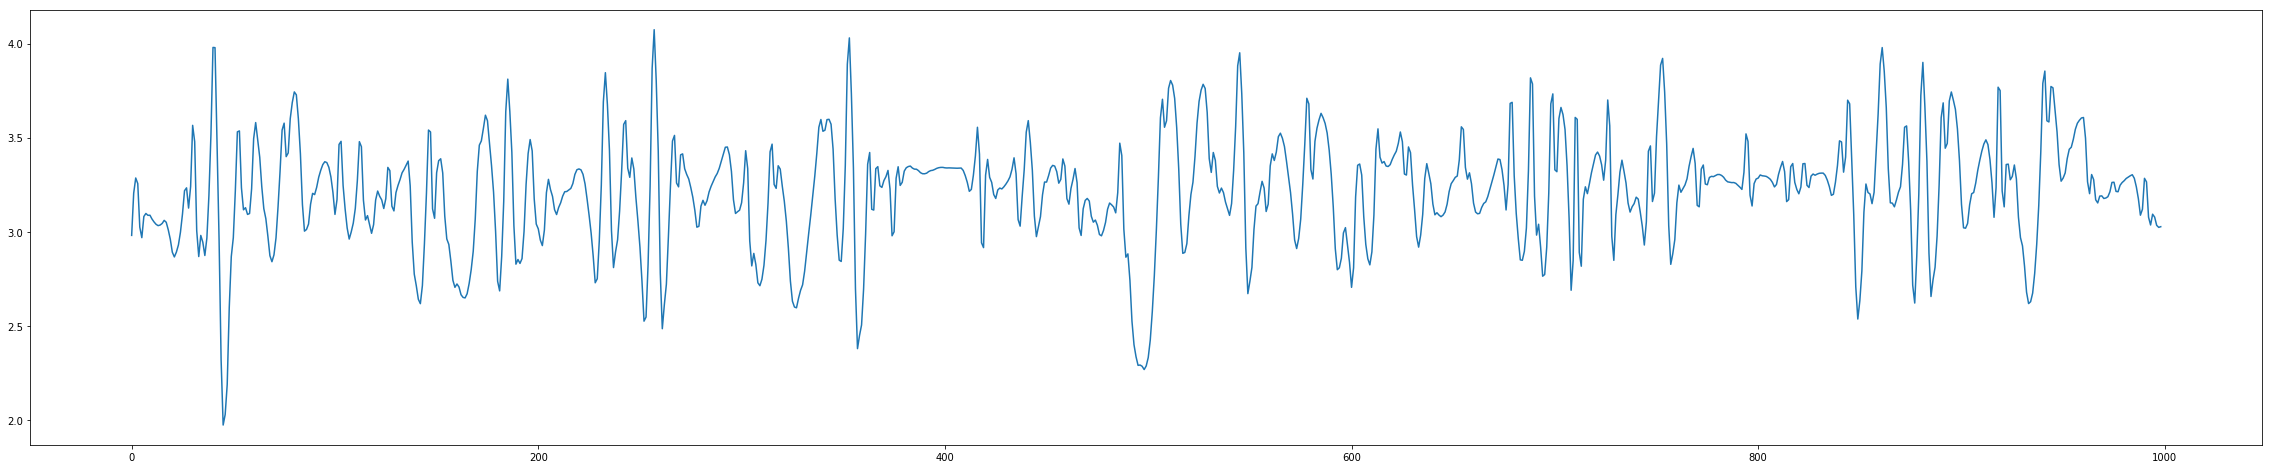

<Figure size 432x288 with 0 Axes>

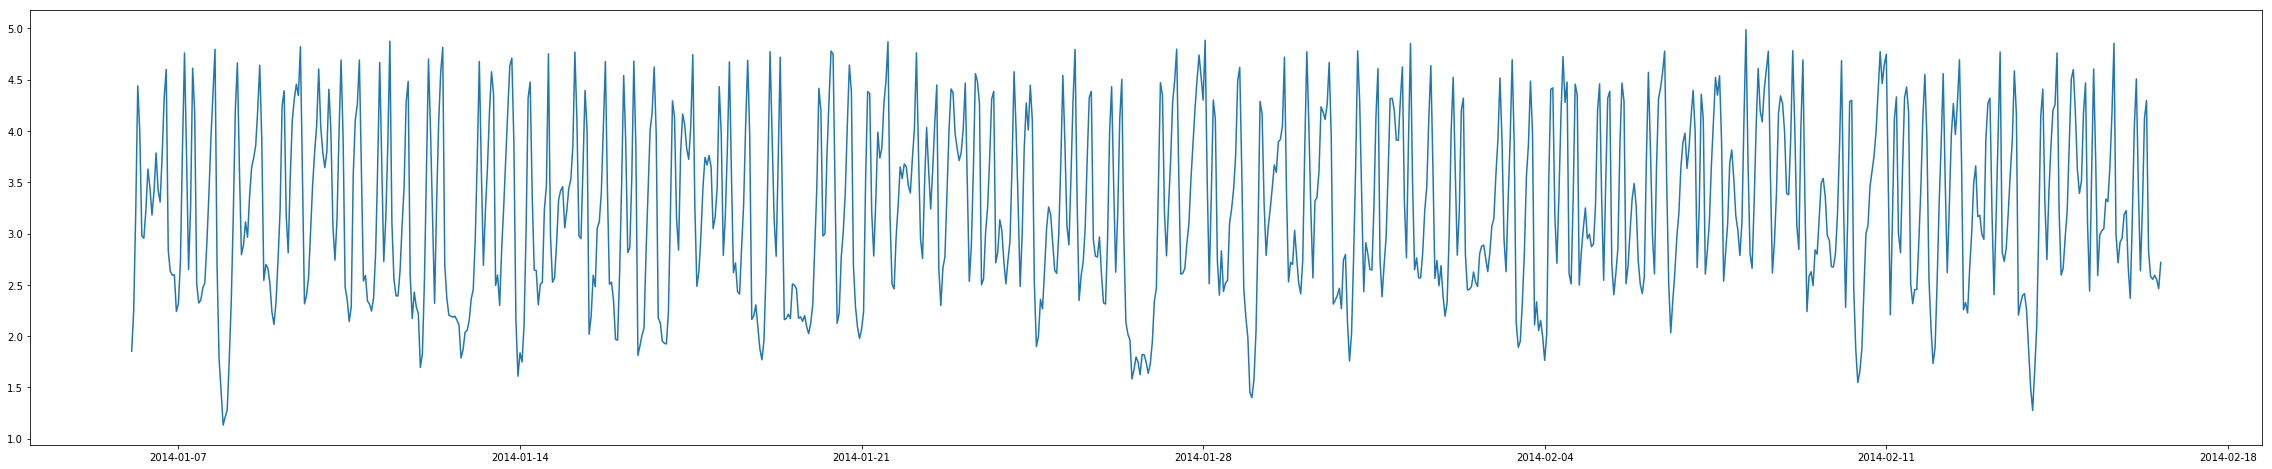

In [36]:
import numpy as np

train_dataset= clean_denoise_datasets(train_dataset , skip_label_clean=True, last_colum_denoise=True)
tune_dataset = clean_denoise_datasets(tune_dataset  , skip_label_clean=False, last_colum_denoise=True)
# test_dataset = clean_denoise_datasets(test_dataset  , skip_label_clean=True, last_colum_denoise=False)

train_label = np.array(train_dataset.iloc[:,-1])
tune_label = np.array(train_dataset.iloc[:,-1])


# Denoise Effect 
signal = train_dataset['L_T7']
denoise_signal = denoise_series(signal)

plt.figure(figsize=(40,8))
plt.plot(denoise_signal[1:1000])
plt.figure(2)
plt.figure(figsize=(40,8))
plt.plot(signal[1:1000])

SAX Discret Data

In [37]:
seq_n=1000
sax_train = train_dataset.copy()
sax_tune  = tune_dataset.copy()
sax_test  = test_dataset.copy()

for data_i, data in enumerate([train_dataset, tune_dataset, test_dataset]):
    print("SAXing Dataset - " + str(data_i))
    for col_i, col in enumerate(data.columns.values):
        if "ATT_FLAG" not in col:
            print(col)
            if data_i == 0:
                sax_train[col] = discritization_by_SAX(data[col], 1000)
            elif data_i == 1:
                sax_tune[col] = discritization_by_SAX(data[col], 1000)
#             else:
#                 sax_test[col] = discritization_by_SAX(data[col], 1000)
        

SAXing Dataset - 0
L_T1
L_T2
L_T3
L_T4
L_T5
L_T6
L_T7
F_PU1
F_PU2
F_PU4
F_PU7
F_PU8
F_PU10
F_V2
P_J280
P_J269
P_J300
P_J256
P_J289
P_J415
P_J302
P_J306
P_J307
P_J317
P_J14
P_J422
SAXing Dataset - 1
L_T1
L_T2
L_T3
L_T4
L_T5
L_T6
L_T7
F_PU1
S_PU1
F_PU2
S_PU2
F_PU3
S_PU3
F_PU4
S_PU4
F_PU5
S_PU5
F_PU6
S_PU6
F_PU7
S_PU7
F_PU8
S_PU8
F_PU9
S_PU9
F_PU10
S_PU10
F_PU11
S_PU11
F_V2
S_V2
P_J280
P_J269
P_J300
P_J256
P_J289
P_J415
P_J302
P_J306
P_J307
P_J317
P_J14
P_J422
SAXing Dataset - 2
L_T1
L_T2
L_T3
L_T4
L_T5
L_T6
L_T7
F_PU1
S_PU1
F_PU2
S_PU2
F_PU3
S_PU3
F_PU4
S_PU4
F_PU5
S_PU5
F_PU6
S_PU6
F_PU7
S_PU7
F_PU8
S_PU8
F_PU9
S_PU9
F_PU10
S_PU10
F_PU11
S_PU11
F_V2
S_V2
P_J280
P_J269
P_J300
P_J256
P_J289
P_J415
P_J302
P_J306
P_J307
P_J317
P_J14
P_J422


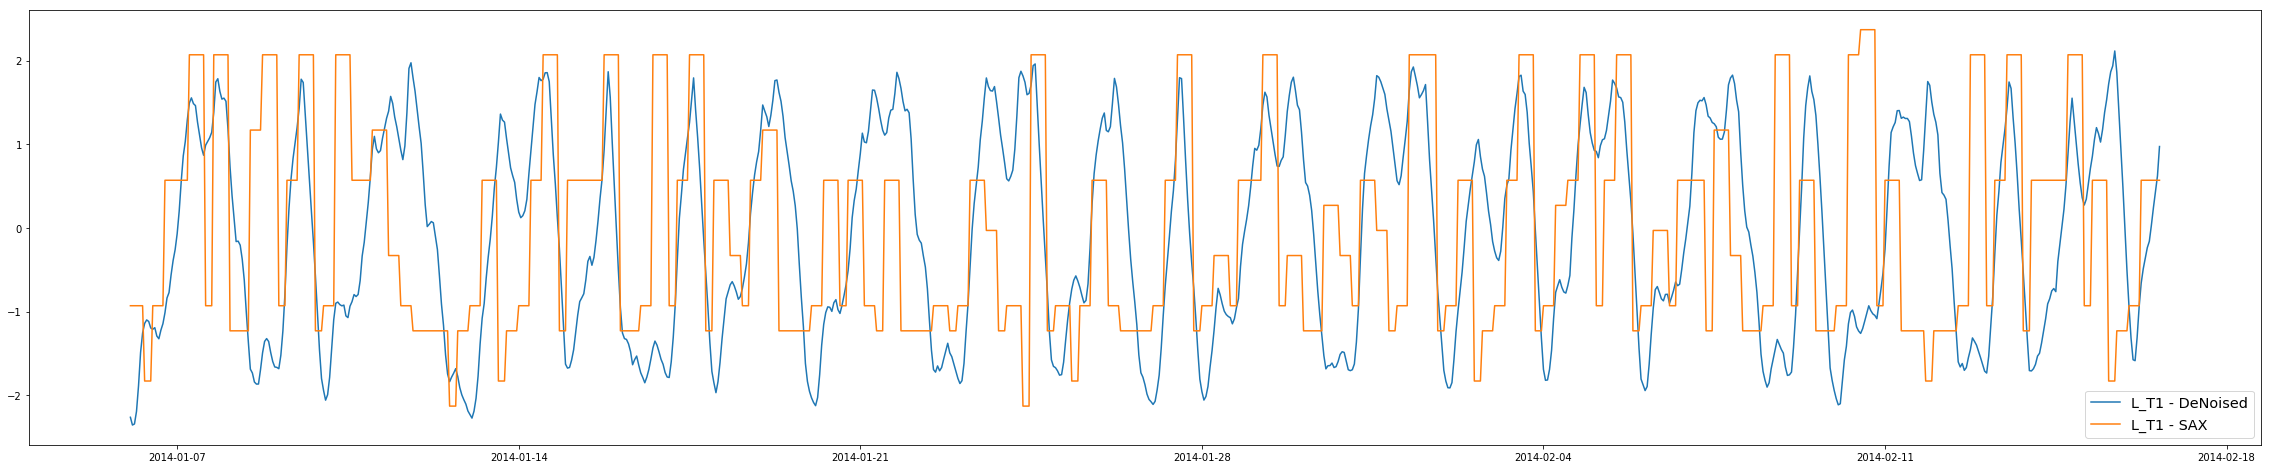

In [38]:
#Visualize SAX
test_col = 'L_T1'
signal_saxed=sax_train[test_col]
signal_norma=train_dataset[test_col]
plt.figure(figsize=(40,8))
plt.plot((signal_norma-signal_norma.mean())[1:1000])
plt.plot((signal_saxed-signal_saxed.mean())[1:1000]*0.3)
plt.legend([test_col + ' - DeNoised', test_col + ' - SAX'],fontsize='x-large')
plt.savefig('SAX.png')

UTIL Function

In [53]:
# coding=utf-8
import os
import time
# import serial
import numpy as np


# Calcula el vector diferencia del vector values pasado
def get_increments( values ):
    length = len(values)
    
    differences = []
    i = 0
    while i < length-1:
        
        f = values[i]
        s = values[i+1]
        
        differences.append(int(s - f))
        
        i += 1

    return differences

# Obtiene la matriz de transición, construyendo una matriz dimension X dimension
# basandose en los valores de data_array
def get_transition_matrix( dimension, data_array):
    middle = int(dimension/2)
    length = len(data_array)
    transition_matrix = np.zeros([dimension,dimension])

    if length > 1:
        i = 0
        while i < length-1:
            # Sumamos 1 a la posicion data_array[i],data_array[i+1] que indica
            # que la transicion data_array[i] --> data_array[i+1] se ha producido
            transition_matrix[data_array[i]+middle][data_array[i+1]+middle] += 1
            i += 1
    
    # Todas las posiciones que contienen un 0, se le suma el valor 10e-6
    transition_matrix[ transition_matrix == 0] += 10e-6

    i = 0
    while i < dimension:
        # Para que la suma de cada una de las filas sume 1, dividimos por
        # la fila por la suma de todos los elementos de la fila.
        transition_matrix[i] = transition_matrix[i]/transition_matrix[i].sum() 
        i += 1
    
    return transition_matrix # a square matrix

# En esta funcion se comprueba que la matriz de transición 
# cumple la condición de que todas sus filas sumen 1.
def satisfy_condition(transition_matrix, dimension):
    i = 0
    condition = True 
    while i < dimension and condition:
        if float(transition_matrix[i].sum()) < 0.999999999:
            condition = False
        
        i += 1

    if not condition:
        print("The transition matrix is malformed.")
    else:
        print("The transition matrix is formed correctly.")
    
    return

# Calcula el minimo likelihood, es decir, devuelve el umbral necesario
# para detectar las anomalías basándonos en unos valores pasados, en una 
# matriz de transición obtenida anteriormente, y un tamaño de ventana.
def minimum_likelihood( values, transition_matrix, window_size ):
    length = len(values)
    middle = int(transition_matrix.shape[1]/2)
    minimum = 1

    i = 0
    # Calculamos para cada ventana, de dimension indicada en window_size, 
    # con incrementos de 1, el likelihood. Guardamos el minimo de ellos.
    while i < length-(window_size+1):
        j = 0
        likeli = 1

        # El bucle produce el likelihood para una ventana
        while j < window_size:
            likeli *= transition_matrix[values[i+(j-1)]+middle][values[i+(j-1)+1]+middle]
            j += 1
        
        if likeli < minimum:
            minimum = likeli

        i += 1 

    return minimum


In [54]:
# np.set_printoptions(threshold=np.nan)

DIM = 100

def mkv(signal, DIM, WINDOWSIZE):
    a=[]
    prediction=np.zeros(len(signal))
    increments=get_increments(signal)
    TM = get_transition_matrix(DIM, increments) 
    middle = int(TM.shape[1]/2)
    satisfy_condition(TM, DIM)

    THRESHOLD = minimum_likelihood(increments, TM, WINDOWSIZE)

    length = len(increments)
    if length > 1:
        i = 0
        while i < length-(WINDOWSIZE+1):      
            j = 0
            likeli = 1
            while j < WINDOWSIZE:
                likeli *= TM[increments[i+(j-1)]+middle][increments[i+(j-1)+1]+middle]
                j += 1
            if likeli < THRESHOLD*2:
                prediction[i+2:i+(j-1)+2]=1
            i += 1
            
    return prediction


def dis_eva(signal, label, WINDOWSIZE):

    pre1=mkv(signal, DIM, WINDOWSIZE)
    FP=evaluation(label,pre1)
    print FP
    
    return FP, pre1

In [69]:
#### Clean Label ####
tune_label = tune_dataset.iloc[:,-1]

label_temp = np.zeros(len(tune_label))

print("Uniqueee---")
print(tune_label.unique())

unique = tune_label.unique()
for i, lab in enumerate(tune_label):
    if "999" in str(tune_label[i]):
        label_temp[i] = '0'
    else:
        label_temp[i] = '1'
print(np.sum(label_temp))
tune_label = label_temp
#####################

prediction = np.zeros(len(sax_tune))
for item in sax_tune: 
    print(item)
    if "ATT_FLAG" not in item:
        signal=sax_tune[item]
        FP, pre_i=dis_eva(signal,tune_label,40)
        if FP>=0.4:
            print item
            prediction=prediction + pre_i

Uniqueee---
['-999\\' '1\\' '-999}']
219.0
L_T1
The transition matrix is formed correctly.
[[3936   22]
 [ 161   58]]
precision: 0.725
recall: 0.2648401826484018
0.725
L_T1
L_T2
The transition matrix is formed correctly.
[[3918   40]
 [ 219    0]]
precision: 0.0
recall: 0.0
0.0
L_T3
The transition matrix is formed correctly.
[[3838  120]
 [ 219    0]]
precision: 0.0
recall: 0.0
0.0
L_T4
The transition matrix is formed correctly.
[[3878   80]
 [ 219    0]]
precision: 0.0
recall: 0.0
0.0
L_T5
The transition matrix is formed correctly.
[[3880   78]
 [ 219    0]]
precision: 0.0
recall: 0.0
0.0
L_T6
The transition matrix is formed correctly.
[[3948   10]
 [ 187   32]]
precision: 0.7619047619047619
recall: 0.1461187214611872
0.7619047619047619
L_T6
L_T7
The transition matrix is formed correctly.
[[3918   40]
 [ 219    0]]
precision: 0.0
recall: 0.0
0.0
F_PU1
The transition matrix is formed correctly.
[[3841  117]
 [ 219    0]]
precision: 0.0
recall: 0.0
0.0
S_PU1
The transition matrix is for

4177
[[3926   32]
 [  83  136]]
precision: 0.8095238095238095
recall: 0.6210045662100456


0.8095238095238095

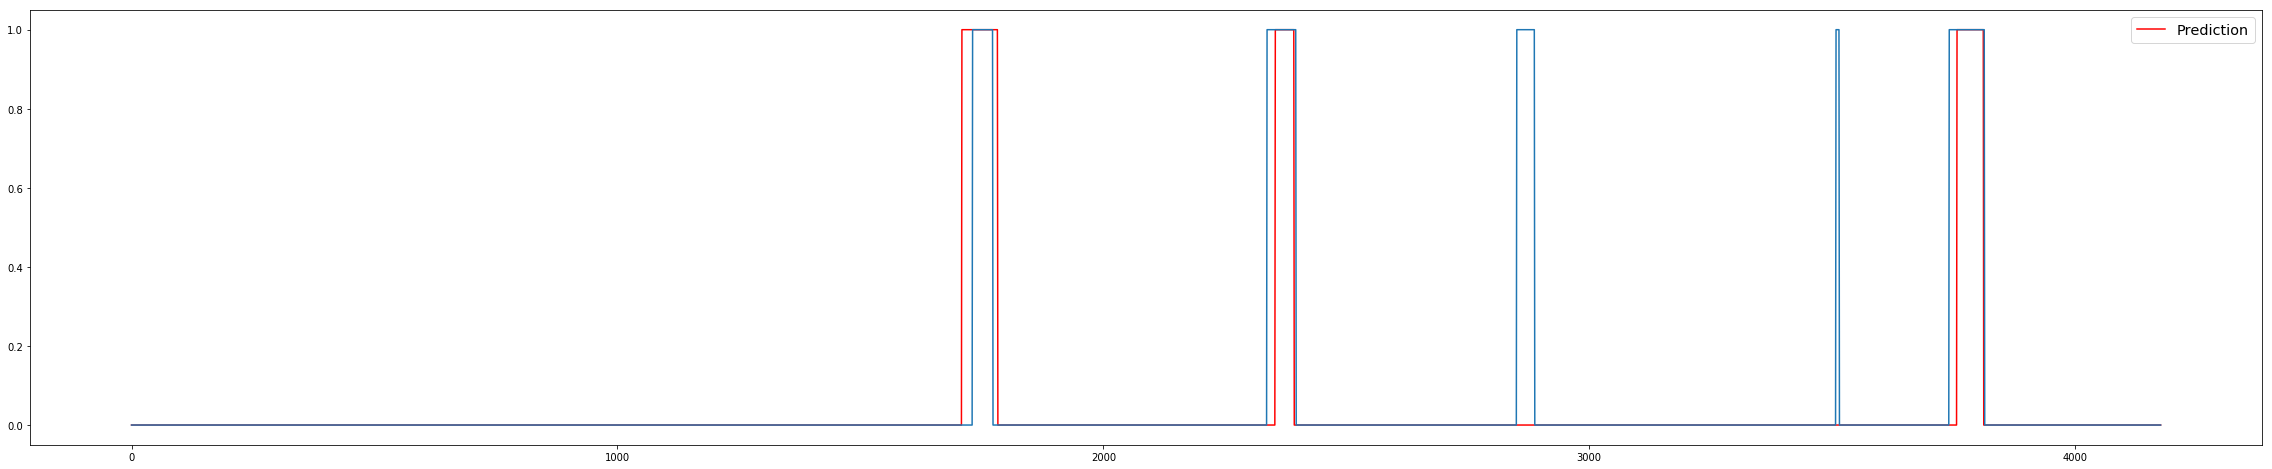

In [71]:
prediction_t=(prediction!=0)*1
print(len(prediction_t))
plt.figure(figsize=(40,8))
plt.plot(prediction_t,'r')
plt.plot(tune_label)
plt.legend(['Prediction'],fontsize='x-large')
evaluation(tune_label,prediction_t)